In [2]:
filepath = r'example_data/Leaf_PM_Nuclei.tif'

from skimage.io import imread
img = imread(filepath)
img_ch0 = img[0,:,:]
img_ch1 = img[1,:,:]

In [3]:
# First import module napari
import napari

# Create an empty viewer object
viewer = napari.Viewer()

# Use viewer.add_image() and pass the image as a variable to visulize the image. Similar to that for matplotlib, set options:
#  * colormap as 'gray'
#  * interpolation (interpolation2d) is 'nearest' (which correspond to minimum interpolation) by default, so no need to specify 
#  * name as 'Raw Image'
viewer.add_image(img_ch0, colormap = 'green', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch1, colormap = 'red', name= 'Raw Image', blending= 'additive')

<Image layer 'Raw Image [1]' at 0x214777aa1c0>

In [4]:
import scipy.ndimage as ndi

sigma = 2
img_smooth = ndi.gaussian_filter(img_ch1, sigma)
viewer.add_image(img_smooth, colormap = 'gray', name= f'Gaussian Smoothed Image (sigma = {sigma})')

<Image layer 'Gaussian Smoothed Image (sigma = 2)' at 0x214786def40>

In [5]:
thresh = 30
img_smooth2 = ndi.gaussian_filter(img_ch1, 5)
void = img_smooth2 > thresh
viewer.add_image(void, colormap = 'gray', name= f'Thresholded Image (sigma = {thresh})')

<Image layer 'Thresholded Image (sigma = 30)' at 0x21468fca670>

In [6]:
from skimage.morphology import disk

# Create SE for mean filtering
# Set radius r for the disk
r = 7
# create disk, save it as SE
SE = disk(r)

from skimage.filters import rank 

background = rank.mean(img_smooth, footprint=SE)

viewer.add_image(background, colormap = 'gray', name= f'Background')
mem = img_smooth > background
viewer.add_image(mem, colormap = 'gray', name= f'Adaptive Filtered')

<Image layer 'Adaptive Filtered' at 0x2146e67d670>

In [7]:
void_holefilled = ndi.binary_fill_holes(void)
viewer.add_image(void_holefilled, colormap = 'gray', name= 'Hole Filled')

<Image layer 'Hole Filled' at 0x2146eeaab80>

In [8]:
mem[void_holefilled == 0] = 1

In [9]:
viewer.add_image(mem, colormap = 'gray', name= f'Adaptive Filtered')

<Image layer 'Adaptive Filtered [1]' at 0x2146ee583a0>

In [10]:
mem_holefilled = ~ndi.binary_fill_holes(~mem)
viewer.add_image(mem_holefilled, colormap = 'gray', name= 'Hole Filled')

<Image layer 'Hole Filled [1]' at 0x214012f08b0>

In [11]:
mem_final = ndi.binary_closing(mem_holefilled, structure=disk(2))
viewer.add_image(mem_final, colormap = 'gray', name= 'Final')

<Image layer 'Final' at 0x2146ed287f0>

In [12]:
cell_labels, _ = ndi.label(~mem_final)
viewer.add_image(cell_labels, colormap='inferno')

<Image layer 'cell_labels' at 0x214015d14c0>

In [13]:
dist_trans = ndi.distance_transform_edt(~mem_final)
viewer.add_image(dist_trans, colormap='viridis', name = 'Distance Transformed')

<Image layer 'Distance Transformed' at 0x2140399f160>

In [13]:
dist_trans_smooth = ndi.gaussian_filter(dist_trans, sigma=3)

from skimage.feature import peak_local_max

seeds = peak_local_max(dist_trans_smooth, min_distance=1)
viewer.add_points(seeds, size=2)

<Points layer 'seeds' at 0x29d9a5b6190>

In [14]:
labels_layer = viewer.add_labels(cell_labels, name='segmentation')

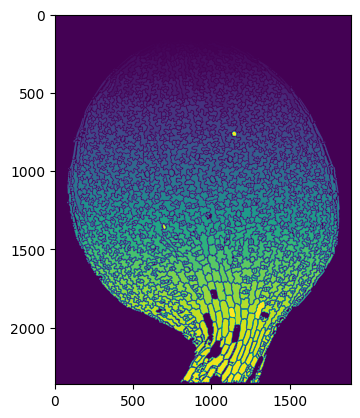

In [17]:
import matplotlib.pyplot as plt

plt.imshow(cell_labels)

In [19]:
import numpy as np

cell_ids = np.unique(cell_labels)

In [20]:
cell_ids

array([   0,    1,    2, ..., 2206, 2207, 2208])

In [21]:
# Extract cell edges
edges = np.zeros_like(cell_labels)

for cell_id in cell_ids:
    if cell_id == 0:
        continue
    cell_roi = cell_labels == cell_id
    # Perform erosion
    eroded_roi_mask = ndi.binary_erosion(cell_roi, iterations=1)
    edge_mask = np.logical_xor(cell_roi, eroded_roi_mask)
    
    edges[edge_mask] = cell_id

In [22]:
viewer.add_image(edges, colormap='prism', name = 'Edges')

<Image layer 'Edges' at 0x21416fc88b0>

In [71]:
# Create dictionary of results

results = {"cell_id"     : [],
           "cell_area"   : [],
           "cell_edges"  : []}

In [72]:
for cell_id in range(2200):
    if cell_id == 0:
        continue
    
    if cell_id%100 == 0:
        print(f'processing cell #{cell_id}')
    
    cell_roi = cell_labels == cell_id
    cell_edge = edges == cell_id
    
    results["cell_id"].append(cell_id)
    results["cell_area"].append(np.sum(cell_roi))
    results["cell_edges"].append(np.sum(cell_edge))

processing cell #100
processing cell #200
processing cell #300
processing cell #400
processing cell #500
processing cell #600
processing cell #700
processing cell #800
processing cell #900
processing cell #1000
processing cell #1100
processing cell #1200
processing cell #1300
processing cell #1400
processing cell #1500
processing cell #1600
processing cell #1700
processing cell #1800
processing cell #1900
processing cell #2000
processing cell #2100


In [73]:
import pandas as pd

results_df = pd.DataFrame(results)

In [74]:
results_df

,cell_id,cell_area,cell_edges
0,1,23227,17519
1,2,94,38
2,3,1164,224
3,4,50,22
4,5,1245,239
...,...,...,...
2194,2195,53,20
2195,2196,1291,141
2196,2197,23,12
2197,2198,417,82


In [75]:
circularity = 4*np.pi*results_df['cell_area']/(results_df['cell_edges']**2)

In [76]:
circularity

0       0.000951
1       0.818032
2       0.291519
3       1.298179
4       0.273895
          ...   
2194    1.665044
2195    0.816015
2196    2.007129
2197    0.779324
2198    0.530668
Length: 2199, dtype: float64

In [77]:
circularity_map = np.zeros_like(cell_labels)

circularity_map = circularity_map.astype(float)

for cell_id in range(2200):
    if cell_id == 0:
        continue
    
    cell_roi = cell_labels == cell_id
    circularity_map[cell_roi] = circularity[cell_id-1]

In [92]:
viewer.add_image(circularity_map, colormap='PRGn', name = 'Circularity')

<Image layer 'Circularity [4]' at 0x214374c6e50>

In [57]:
np.max(circularity_map)

2

In [79]:
from skimage.measure import regionprops

props = regionprops(cell_labels)

In [84]:
props[2].area

1164.0

In [89]:
props[2100].area_convex

52.0

In [90]:
solidity_map = np.zeros_like(cell_labels)

solidity_map = solidity_map.astype(float)


for cell_id in range(2100):
    if cell_id == 0:
        continue
        
    cell_roi = cell_labels == cell_id
    solidity_map[cell_roi] = props[cell_id].area_convex/props[cell_id].area

In [91]:
viewer.add_image(solidity_map, colormap='gray', name = 'Solidity')

<Image layer 'Solidity' at 0x21420f52a90>